In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from matplotlib import cm
from sklearn.metrics import pairwise_distances_argmin_min
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
import os
import math
import seaborn as sns
from collections import defaultdict

def schwefel(coordinates):
    result = 0
    for coordinate in coordinates:
        result += coordinate * math.sin(math.sqrt(abs(coordinate)))
    return 418.9829 * len(coordinates) - result

def sphere(x):
    return sum([xi**2 for xi in x])

def compute_inertia(data, labels, centroids):
    inertia = 0
    for i in range(len(centroids)):
        cluster_points = data[labels == i]
        inertia += np.sum((cluster_points - centroids[i])**2)
    return inertia

def map_and_remap_clusters(
    gen_index,
    prev_clusters_members, curr_clusters_members,
    clusters_array, pop_data,
    global_id_counter
):
    if gen_index > 0 and global_id_counter == 0:
        global_id_counter = max(prev_clusters_members.keys()) + 1

    if gen_index == 0:
        new_ids = {}
        for cid in curr_clusters_members.keys():
            new_ids[cid] = global_id_counter
            global_id_counter += 1

        new_clusters_array = np.array([
            new_ids[cl] if cl in new_ids else -1 for cl in clusters_array
        ])
        new_centroids = np.array([
            np.mean(pop_data[np.array(new_clusters_array) == gid], axis=0)
            for gid in sorted(new_ids.values())
        ])
        new_cluster_members = {
            new_ids[cid]: members for cid, members in curr_clusters_members.items()
        }

        return new_clusters_array, new_centroids, new_cluster_members, global_id_counter

    # === 1. Každý starý cluster navrhne JEDEN nejlepší nový cluster ===
    suggestions = defaultdict(list)

    for prev_id, prev_members in prev_clusters_members.items():
        best_score = -1
        best_curr_id = None
        for curr_id, curr_members in curr_clusters_members.items():
            intersection = len(prev_members & curr_members)
            union = len(prev_members | curr_members)
            if union == 0:
                continue
            jaccard = intersection / union
            if jaccard > best_score:
                best_score = jaccard
                best_curr_id = curr_id
        if best_curr_id is not None:
            suggestions[best_curr_id].append((prev_id, best_score))

    # === Debug výpis návrhů ===
    #print("\n--- Návrhy pro nové clustery (přesně jeden od každého předka) ---")
    #for curr_id, proposals in suggestions.items():
        #print(f"Nový cluster {curr_id}: {[f'{pid} ({score:.2f})' for pid, score in sorted(proposals, key=lambda x: -x[1])]}")

    # === 2. Výběr nejlepšího nepoužitého předka
    used_prev_ids = set()
    id_mapping = {}
    for curr_id, proposals in suggestions.items():
        proposals.sort(key=lambda x: -x[1])  # podle Jaccarda sestupně
        for prev_id, score in proposals:
            if prev_id not in used_prev_ids:
                id_mapping[curr_id] = prev_id
                used_prev_ids.add(prev_id)
                #print(f"✔️ Cluster {curr_id} byl namapován na {prev_id} (Jaccard: {score:.2f})")
                break

    # === 3. Zbytek nových clusterů dostane nové ID
    for curr_id in curr_clusters_members:
        if curr_id not in id_mapping:
            id_mapping[curr_id] = global_id_counter
            #print(f"🆕 Cluster {curr_id} nedostal žádného předka – přiděleno nové ID: {global_id_counter}")
            global_id_counter += 1

    # === 4. Mapování pole clusterů
    new_clusters_array = np.array([
        id_mapping[cl] if cl in id_mapping else -1 for cl in clusters_array
    ])

    # === 5. Přepočet centroidů
    new_centroids = []
    new_cluster_ids = sorted(set(id_mapping.values()))
    for gid in new_cluster_ids:
        member_data = pop_data[np.array(new_clusters_array) == gid]
        if len(member_data) > 0:
            new_centroids.append(np.mean(member_data, axis=0))
    new_centroids = np.array(new_centroids)

    # === 6. Členové clusterů podle nového mapování
    new_cluster_members = {}
    for curr_id, members in curr_clusters_members.items():
        gid = id_mapping[curr_id]
        new_cluster_members[gid] = members

    return new_clusters_array, new_centroids, new_cluster_members, global_id_counter

def compute_fitness(individual):
    return np.sum(np.square(individual))

def draw_colored_dendrogram(merge_history, labels, num_points):
    fig, ax = plt.subplots(figsize=(12, 6))
    positions = {i: i for i in range(num_points)}  # x-ové pozice pro jednotlivé listy
    heights = {}  # y-ové výšky (vzdálenosti) pro spojení
    cluster_colors = cm.tab10.colors  # 10 předdefinovaných barev (opakují se)
    color_map = {}  # cluster_id -> barva

    current_idx = num_points  # virtuální indexy pro spojení (větve)

    # Barva každého původního bodu podle jeho finálního clusteru
    for i, cluster_id in enumerate(labels):
        color_map[i] = cluster_colors[cluster_id % len(cluster_colors)]

    # Kreslení jednotlivých spojení (větví)
    for idx1, idx2, dist, size in merge_history:
        x1 = positions[idx1]
        x2 = positions[idx2]
        y = dist

        # Barvy levé a pravé větve
        c1 = color_map.get(idx1, 'black')
        c2 = color_map.get(idx2, 'black')
        merged_color = c1 if c1 == c2 else 'gray'

        # Svislé čáry
        ax.plot([x1, x1], [heights.get(idx1, 0), y], c=c1, linewidth=2)
        ax.plot([x2, x2], [heights.get(idx2, 0), y], c=c2, linewidth=2)

        # Vodorovná čára spojení
        ax.plot([x1, x2], [y, y], c=merged_color, linewidth=2)

        # Nový uzel pro další slučování
        positions[current_idx] = (x1 + x2) / 2
        heights[current_idx] = y
        color_map[current_idx] = merged_color

        current_idx += 1

    ax.set_title("Barevný dendrogram (vlastní kreslení)")
    ax.set_xlabel("Index vzorku")
    ax.set_ylabel("Vzdálenost")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def hierarchical_clustering(data, num_clusters=None, min_distance=None):
    clusters = {i: [i] for i in range(len(data))}
    centroids = {i: data[i] for i in range(len(data))}
    merge_history = []
    cluster_sizes = {i: 1 for i in range(len(data))}

    while True:
        min_dist = float("inf")
        to_merge = None
        
        cluster_keys = list(clusters.keys())
        for i in range(len(cluster_keys)):
            for j in range(i + 1, len(cluster_keys)):
                c1, c2 = cluster_keys[i], cluster_keys[j]
                dist = np.linalg.norm(centroids[c1] - centroids[c2])
                if dist < min_dist:
                    min_dist = dist
                    to_merge = (c1, c2)

        if to_merge is None:
            break

        if min_distance is not None and min_dist > min_distance:
            break

        if num_clusters is not None and len(clusters) <= num_clusters:
            break

        c1, c2 = to_merge
        new_cluster = clusters[c1] + clusters[c2]
        new_centroid = np.mean([data[i] for i in new_cluster], axis=0)

        # Aktualizace clusterů
        new_key = max(clusters.keys()) + 1
        clusters[new_key] = new_cluster
        centroids[new_key] = new_centroid

        merge_history.append((c1, c2, min_dist, len(new_cluster)))
        cluster_sizes[max(clusters.keys()) + 1] = len(new_cluster)

        del clusters[c1]
        del clusters[c2]
        del centroids[c1]
        del centroids[c2]

    labels = np.zeros(len(data), dtype=int)
    for cluster_idx, cluster_points in enumerate(clusters.values()):
        for point in cluster_points:
            labels[point] = cluster_idx

    return labels, merge_history

def run(dataset, num_clusters, step, fintess_method, clustering_method_name, evol_name):
    output_dir = os.path.join("html_report", evol_name, fintess_method.__name__, clustering_method_name)
    images_dir = os.path.join(output_dir, "images")
    os.makedirs(images_dir, exist_ok=True)

    html_parts = [
        "<html><head><meta charset='utf-8'><title>Clustering Report</title></head><body>",
        "<h1>Agregační shlukování – Vývoj</h1>"
    ]

    df = pd.read_csv(dataset)
    id_cluster_map = defaultdict(list)
    cluster_counts = []
    size_history = []
    centroid_history = []
    inertia_history = []
    cluster_members_by_gen = {}
    global_cluster_map = {}  # {generation: {local_cluster_id: global_id}}
    global_id_counter = 0

    unique_generations = sorted(df["generation"].unique())

    #selected_generations = [unique_generations[0]] + unique_generations[step-1::step] + [unique_generations[-1]]
    selected_generations = list(dict.fromkeys(
        [unique_generations[0]] + unique_generations[step-1::step] + [unique_generations[-1]]
    ))


    first_gen_data = df[df["generation"] == unique_generations[0]].drop(columns=["generation", "id"]).values
    pca = PCA(n_components=2)
    pca.fit(first_gen_data)

    #for gen in selected_generations:
    for gen_ind, gen in enumerate(selected_generations):
        pop_data = df[df["generation"] == gen].drop(columns=["generation", "id"]).values
        reduced_data = pca.transform(pop_data)

        pairwise_distances = cdist(pop_data, pop_data)
        max_distance = np.max(pairwise_distances)
        min_dist_threshold = 0.85 * max_distance


        #clusters, merge_history = hierarchical_clustering(pop_data, min_distance=min_dist_threshold)
        # Inicializace modelu s parametrem vzdálenosti
        model = AgglomerativeClustering(distance_threshold=min_dist_threshold, n_clusters=None)

        # Fitnutí modelu
        model.fit(pop_data)

        # Výsledné přiřazení klastrů
        clusters = model.labels_

        # Spočítej centroidy
        centroids = []
        for i in range(min(clusters), max(clusters)+1):
            if i == -1:
                continue
            members = pop_data[clusters == i]
            if len(members) > 0:
                centroid = np.mean(members, axis=0)
                centroids.append(centroid)
        centroid_history.append(centroids)
        inertia = compute_inertia(pop_data, clusters, centroids)
        inertia_history.append(inertia)


        # Ulož počet clusterů
        cluster_counts.append(len(set(clusters)))

        # Ulož mapu ID → cluster
        ids = df[df["generation"] == gen]["id"].values
        #for ident, cl in zip(ids, clusters):
        #    id_cluster_map[ident].append(cl)

        # === Uložení členů clusterů pro aktuální generaci ===
        #cluster_to_ids = defaultdict(set)
        #for ident, cl in zip(ids, clusters):
        #    cluster_to_ids[cl].add(ident)
        #cluster_members_by_gen[gen] = cluster_to_ids

        # === Uložení členů clusterů pro aktuální generaci – LOKÁLNÍ ID (kvůli Jaccardu)
        #cluster_to_ids = defaultdict(set)
        #for ident, cl in zip(ids, clusters):
        #    cluster_to_ids[cl].add(ident)
        #cluster_members_by_gen[gen] = cluster_to_ids  # pro mapování

        # === Přemapování clusterů pomocí Jaccard (bez globální mapy)
        prev_clusters_members = cluster_members_by_gen[selected_generations[gen_ind - 1]] if gen_ind > 0 else None
        curr_clusters_members = defaultdict(set)
        for ident, cl in zip(ids, clusters):
            if cl != -1:
                curr_clusters_members[cl].add(ident)

        if prev_clusters_members is not None:
            clusters, centroids, curr_clusters_members, global_id_counter = map_and_remap_clusters(
                gen_ind,
                prev_clusters_members,
                curr_clusters_members,
                clusters,
                pop_data,
                global_id_counter
            )


        cluster_members_by_gen[gen] = curr_clusters_members

        # === Až teď uložíme do `id_cluster_map`
        for ident, cl in zip(ids, clusters):
            id_cluster_map[ident].append(cl)

        # Spočítej velikosti
        #sizes = [np.sum(clusters == i) for i in sorted(set(clusters))]
        #size_history.append(sizes)
        #print(f"\nGenerace {gen} - {len(sizes)} clusterů")
        #for i, size in enumerate(sizes):
        #    print(f"  Cluster {i}: {size} jedinců")

        # Výpočet WCSS (inercie) pro hierarchické shlukování
        #wcss = 0.0
        #for i, centroid in enumerate(centroids):
        #    members = pop_data[clusters == i]
        #    if len(members) > 0:
        #        dists = np.linalg.norm(members - centroid, axis=1)
        #        wcss += np.sum(dists ** 2)
        #wcss_history.append(wcss)

        # === Sledování centroidů, velikosti a kvality ===
        #centroid_history.append(centroids)
        #size_history.append([np.sum(clusters == i) for i in range(num_clusters)])
        #inertia = compute_inertia(pop_data, clusters, centroids)
        #inertia_history.append(inertia)



        plt.figure(figsize=(6, 6))
        scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)

        handles, _ = scatter.legend_elements(prop="colors")
        legend_labels = [f"Shluk {cl}" for cl in sorted(set(clusters))]  # ← reálné názvy

        plt.legend(handles, legend_labels, title="Shluky", loc='upper center', bbox_to_anchor=(0.5, -0.12),
                ncol=5, fontsize=8, frameon=False)
        plt.title(f"Generace {gen} - Agregační Shlukování")
        plt.xlabel("PCA komponent 1")
        plt.ylabel("PCA komponent 2")
        plt.tight_layout()
        scatter_path = os.path.join(images_dir, f"scatter_gen_{gen:03d}.png")
        plt.savefig(scatter_path)
        plt.close()

        html_parts.append(f"<h2>Generace {gen}</h2>")
        html_parts.append(f"<img src='images/{os.path.basename(scatter_path)}' width='600'><br>")


        # === Histogram velikostí clusterů ===
        unique_labels = sorted(set(clusters))
        cluster_sizes = [np.sum(clusters == label) for label in unique_labels]

        # Filtrování jen neprázdných shluků
        filtered = [(label, size) for label, size in zip(unique_labels, cluster_sizes) if size > 0]
        if not filtered:
            filtered_labels, filtered_sizes = [], []
        else:
            filtered_labels, filtered_sizes = zip(*filtered)

        # Vykreslení histogramu s indexy místo skutečných labelů jako souřadnic
        plt.figure(figsize=(6, 4))
        x_pos = range(len(filtered_labels))  # [0, 1, 2, ...]
        bars = plt.bar(x_pos, filtered_sizes, color='skyblue', edgecolor='black')

        # Popisky pod osou
        plt.xticks(ticks=x_pos, labels=[f"Shluk {label}" for label in filtered_labels], rotation=90)

        plt.ylabel("Počet jedinců")
        plt.title(f"Histogram velikostí shluků - generace {gen}")
        plt.grid(True, axis='y')
        plt.tight_layout()

        # Uložení
        hist_path = os.path.join(images_dir, f"histogram_gen_{gen:03d}.png")
        plt.savefig(hist_path)
        plt.close()

        # Přidání do HTML
        html_parts.append(f"<img src='images/{os.path.basename(hist_path)}' width='600'><br>")


        # === Analýza stability clusterů mezi generacemi ===
        if gen_ind > 0:
            previous_gen = selected_generations[gen_ind - 1]
            current_gen = gen

            cluster_transitions = defaultdict(lambda: defaultdict(int))  # prev_cluster -> current_cluster -> count

            for ident, history in id_cluster_map.items():
                if len(history) > gen_ind:
                    prev_label = history[gen_ind - 1]
                    curr_label = history[gen_ind]
                    cluster_transitions[prev_label][curr_label] += 1

            html_parts.append(f"<h3>Stabilita mezi generací {previous_gen} → {current_gen}:</h3>")
            html_parts.append("<pre>")
            for prev_label, curr_counts in cluster_transitions.items():
                total = sum(curr_counts.values())
                for curr_label, count in curr_counts.items():
                    percent = count / total * 100 if total > 0 else 0
                    html_parts.append(f"  Shluk {prev_label} → {curr_label}: {count} jedinců ({percent:.1f} %)")
            html_parts.append("</pre>")

        # === Mapování pomocí Jaccardova indexu mezi předchozí a aktuální generací ===
        if gen_ind > 0:
            gen_a = selected_generations[gen_ind - 1]
            gen_b = gen

            clusters_a = cluster_members_by_gen[gen_a]
            clusters_b = cluster_members_by_gen[gen_b]

            html_parts.append(f"<h3>Jaccardovo mapování a overlap: Generace {gen_a} → {gen_b}</h3>")
            html_parts.append("<pre>")

            for ca, members_a in clusters_a.items():
                best_jaccard = 0
                best_cb = None

                for cb, members_b in clusters_b.items():
                    intersection = len(members_a & members_b)
                    union = len(members_a | members_b)
                    jaccard = intersection / union if union > 0 else 0
                    overlap = len(members_a & members_b) / min(len(members_a), len(members_b))

                    if jaccard > best_jaccard:
                        best_jaccard = jaccard
                        best_cb = cb

                if best_cb is not None:
                    intersection = len(members_a & clusters_b[best_cb])
                    denom = min(len(members_a), len(clusters_b[best_cb]))
                    overlap = intersection / denom if denom > 0 else 0
                    html_parts.append(f" - Shluk {ca} → {best_cb} (Jaccard: {best_jaccard:.2f}, Overlap: {overlap:.2f})")
                else:
                    html_parts.append(f" - Shluk {ca} → žádný vhodný přechod")

            html_parts.append("</pre>")

            # === Posun centroidů mezi předchozí a aktuální generací ===
            if gen_ind > 0:
                html_parts.append(f"<h4>Posun centroidů mezi generací {selected_generations[gen_ind - 1]} → {gen}:</h4>")
                html_parts.append("<pre>")
                centroids_a = centroid_history[gen_ind - 1]
                centroids_b = centroid_history[gen_ind]
                for j in range(min(len(centroids_a), len(centroids_b))):
                    dist = np.linalg.norm(centroids_a[j] - centroids_b[j])
                    html_parts.append(f" - Shluk {j}: {dist:.4f}")
                html_parts.append("</pre>")




        # === Boxplot fitness hodnot v jednotlivých clusterech ===
        gen_data = df[df["generation"] == gen]
        pop_values = gen_data.drop(columns=["generation", "id"]).values
        fitness_values = np.array([fintess_method(ind) for ind in pop_values])

        # Získání unikátních cluster ID (vynecháme -1 = noise)
        cluster_ids = sorted(set(clusters) - {-1})

        # Inicializace slovníku
        cluster_fitness = {cl: [] for cl in cluster_ids}

        # Naplnění fitness hodnot do jednotlivých clusterů
        for i, cl in enumerate(clusters):
            if cl in cluster_fitness:
                cluster_fitness[cl].append(fitness_values[i])

        # Vykreslení boxplotu
        plt.figure(figsize=(8, 5))
        plt.boxplot([cluster_fitness[cl] for cl in cluster_ids],
                    labels=[f"Shluk {cl}" for cl in cluster_ids])
        plt.xticks(rotation=90)  # <--- otočení popisků
        plt.xlabel("Shluk")
        plt.ylabel("Fitness")
        plt.title(f"Distribuce fitness hodnot – generace {gen}")
        plt.grid(True)
        plt.tight_layout()
        #plt.show()
        box_path = os.path.join(images_dir, f"boxplot_gen_{gen:03d}.png")
        plt.savefig(box_path)
        plt.close()
        html_parts.append(f"<img src='images/{os.path.basename(box_path)}' width='600'><br>")

        

        #TODO: Nutno upravit a udělat custom jelikož to vůbec nesedí k vytvořeným clusterům
        #linkage_matrix = linkage(reduced_data, method='ward')
        #linkage_matrix = linkage(pop_data, method='ward')
        #plt.figure(figsize=(8, 5))
        #dendrogram(linkage_matrix, truncate_mode="level", p=5)  # Zkrácení na 5 úrovní pro lepší čitelnost
        #dendrogram(linkage_matrix, labels=df[df["generation"] == gen]["id"].values)
        #plt.title(f"Generation {gen} - Dendrogram")
        #plt.xlabel("Sample index")
        #plt.ylabel("Distance")
        #plt.show()

        #switch_counts = {}
        #for ident, history in id_cluster_map.items():
        #    switches = sum(1 for a, b in zip(history, history[1:]) if a != b)
        #    switch_counts[ident] = switches

        #total = len(switch_counts)
        #same = sum(1 for s in switch_counts.values() if s == 0)
        #once = sum(1 for s in switch_counts.values() if s == 1)
        #many = sum(1 for s in switch_counts.values() if s > 1)

        #print("Statistiky pohybu mezi clustery:")
        #print(f"Celkem jedinců: {total}")
        #print(f"Zůstali ve stejném clusteru: {same} ({same/total*100:.1f} %)")
        #print(f"Změnili cluster jednou: {once} ({once/total*100:.1f} %)")
        #print(f"Změnili cluster vícekrát: {many} ({many/total*100:.1f} %)")

        #draw_colored_dendrogram(merge_history, clusters, num_points=len(pop_data))
    
    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, cluster_counts, marker='o')
    plt.xlabel("Generace")
    plt.ylabel("Počet shluků")
    plt.title("Vývoj počtu shluků v čase")
    plt.grid(True)
    plt.tight_layout()
    #plt.show()
    time_cluster_path = os.path.join(images_dir, f"time_cluster_gen_{gen:03d}.png")
    plt.savefig(time_cluster_path)
    plt.close()
    html_parts.append(f"<img src='images/{os.path.basename(time_cluster_path)}' width='600'><br>")

    all_global_ids = sorted({cid for gen_map in cluster_members_by_gen.values() for cid in gen_map})
    global_id_to_index = {cid: i for i, cid in enumerate(all_global_ids)}

    cluster_size_array = np.zeros((len(selected_generations), len(all_global_ids)))

    for gen_idx, gen in enumerate(selected_generations):
        gen_clusters = cluster_members_by_gen[gen]
        for gid, members in gen_clusters.items():
            idx = global_id_to_index[gid]
            cluster_size_array[gen_idx, idx] = len(members)

    plt.figure(figsize=(12, 5))
    for j, gid in enumerate(all_global_ids):
        plt.plot(selected_generations, cluster_size_array[:, j], label=f"Shluk {gid}")

    plt.xlabel("Generace")
    plt.ylabel("Počet jedinců")
    plt.title("Vývoj velikosti shluků v čase")
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
    #        ncol=5, fontsize=8, frameon=False)
    plt.grid(True)
    plt.tight_layout()
    #plt.show()
    size_cluster_path = os.path.join(images_dir, f"size_cluster_gen_{gen:03d}.png")
    plt.savefig(size_cluster_path)
    plt.close()
    html_parts.append(f"<img src='images/{os.path.basename(size_cluster_path)}' width='1200'><br>")


    plt.figure(figsize=(14, 6))
    sns.heatmap(cluster_size_array.T, cmap="viridis", cbar_kws={"label": "Počet jedinců"})
    plt.xlabel("Generace")
    plt.ylabel("Globální ID shluku")
    plt.title("Heatmapa vývoje velikosti shluků v čase")
    plt.tight_layout()
    size_cluster_heatmap = os.path.join(images_dir, f"Size_cluster_heatmap_gen_{gen:03d}.png")
    plt.savefig(size_cluster_heatmap)
    plt.close()
    html_parts.append(f"<img src='images/{os.path.basename(size_cluster_heatmap)}' width='1200'><br>")

    num_clusters = cluster_size_array.shape[1]
    chunk_size = 50  # uprav dle potřeby (např. 50)
    num_chunks = (num_clusters + chunk_size - 1) // chunk_size  # zaokrouhlení nahoru

    if num_clusters > 50:
        for i in range(num_chunks):
            start = i * chunk_size
            end = min(start + chunk_size, num_clusters)

            # Získání skutečných globálních ID pro tento chunk
            chunk_ids = all_global_ids[start:end]
            chunk_array = cluster_size_array[:, start:end].T  # každý řádek = jeden cluster

            plt.figure(figsize=(14, 6))
            sns.heatmap(chunk_array, cmap="viridis", 
                        cbar_kws={"label": "Počet jedinců"},
                        yticklabels=chunk_ids)  # správné ID na ose Y
            plt.xlabel("Generace")
            plt.ylabel("Globální ID shluku")
            plt.title(f"Heatmapa vývoje velikosti shluků (Clustery {chunk_ids[0]}–{chunk_ids[-1]})")
            plt.tight_layout()

            heatmap_path = os.path.join(images_dir, f"size_cluster_heatmap_{chunk_ids[0]:03d}_{chunk_ids[-1]:03d}.png")
            plt.savefig(heatmap_path)
            plt.close()

            html_parts.append(f"<img src='images/{os.path.basename(heatmap_path)}' width='1200'><br>")


    # === Vývoj průměrné vzdálenosti mezi centroidy ===
    average_intercentroid_distances = []
    for centroids in centroid_history:
        if len(centroids) < 2:
            average_intercentroid_distances.append(0)
            continue
        dists = cdist(centroids, centroids)
        upper_triangle = dists[np.triu_indices_from(dists, k=1)]
        avg_dist = np.mean(upper_triangle)
        average_intercentroid_distances.append(avg_dist)

    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, average_intercentroid_distances, marker='o', color='purple')
    plt.xlabel("Generace")
    plt.ylabel("Průměrná vzdálenost mezi centroidy")
    plt.title("Vývoj vzdáleností mezi centroidy")
    plt.grid(True)
    plt.tight_layout()
    #plt.show()
    distance_centroid_path = os.path.join(images_dir, f"distance_centroid_gen_{gen:03d}.png")
    plt.savefig(distance_centroid_path)
    plt.close()
    html_parts.append(f"<img src='images/{os.path.basename(distance_centroid_path)}' width='600'><br>")

    
    #for i in range(len(centroid_history) - 1):
        #print(f"\nPosun centroidů mezi generací {selected_generations[i]} a {selected_generations[i+1]}:")
    #    html_parts.append(f"<h3>Posun centroidů mezi generací {selected_generations[i]} a {selected_generations[i+1]}:</h3>")
    #    html_parts.append("<pre>")
    #    for j in range(min(len(centroid_history[i]), len(centroid_history[i+1]))):
    #        dist = np.linalg.norm(centroid_history[i][j] - centroid_history[i+1][j])
            #print(f" - Cluster {j}: {dist:.4f}")
    #        html_parts.append(f" - Cluster {j}: {dist:.4f}")
    #    html_parts.append("</pre>")
    
    # === Vývoj WCSS ===
    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, inertia_history, marker='o')
    plt.xlabel("Generace")
    plt.ylabel("WCSS (inercie)")
    plt.title("Vývoj kvality shluků (inercie) – Agregační shlukování")
    plt.grid(True)
    plt.tight_layout()
    #plt.show()
    wcss_path = os.path.join(images_dir, f"wcss_gen_{gen:03d}.png")
    plt.savefig(wcss_path)
    plt.close()
    html_parts.append(f"<img src='images/{os.path.basename(wcss_path)}' width='600'><br>")


    #print("\n=== Mapování clusterů mezi generacemi pomocí Jaccardova indexu ===")
    #html_parts.append("<h2>=== Mapování clusterů mezi generacemi pomocí Jaccardova indexu ===</h2>")
    #for i in range(len(selected_generations) - 1):
    #    gen_a = selected_generations[i]
    #    gen_b = selected_generations[i + 1]

    #    clusters_a = cluster_members_by_gen[gen_a]
    #    clusters_b = cluster_members_by_gen[gen_b]

        #print(f"\nGenerace {gen_a} → {gen_b}:")
    #    html_parts.append(f"<h3>Generace {gen_a} → {gen_b}:</h3>")
    #    html_parts.append("<pre>")

    #    for ca, members_a in clusters_a.items():
    #        best_jaccard = 0
    #        best_cb = None

    #        for cb, members_b in clusters_b.items():
    #            intersection = len(members_a & members_b)
    #            union = len(members_a | members_b)
    #            jaccard = intersection / union if union > 0 else 0

    #            if jaccard > best_jaccard:
    #                best_jaccard = jaccard
    #                best_cb = cb

    #        if best_cb is not None:
                #print(f" - Cluster {ca} → {best_cb} (Jaccard: {best_jaccard:.2f})")
    #            html_parts.append(f" - Cluster {ca} → {best_cb} (Jaccard: {best_jaccard:.2f})")
    #        else:
                #print(f" - Cluster {ca} → žádný vhodný přechod")
    #            html_parts.append(f" - Cluster {ca} → žádný vhodný přechod")
    #    html_parts.append("</pre>")

    #html_parts.append("</body></html>")

    html_path = os.path.join(output_dir, "report.html")
    with open(html_path, "w", encoding="utf-8") as f:
        f.write("\n".join(html_parts))

    print(f"✅ HTML report byl uložen do: {html_path}")

In [6]:
run("population_log_DE_sphere.csv", 3, 1, sphere, "Agregacni", "DE")

✅ HTML report byl uložen do: html_report\DE\sphere\Agregacni\report.html


In [7]:
run("population_log_DE_schwefel.csv", 3, 1, schwefel, "Agregacni", "DE")

✅ HTML report byl uložen do: html_report\DE\schwefel\Agregacni\report.html


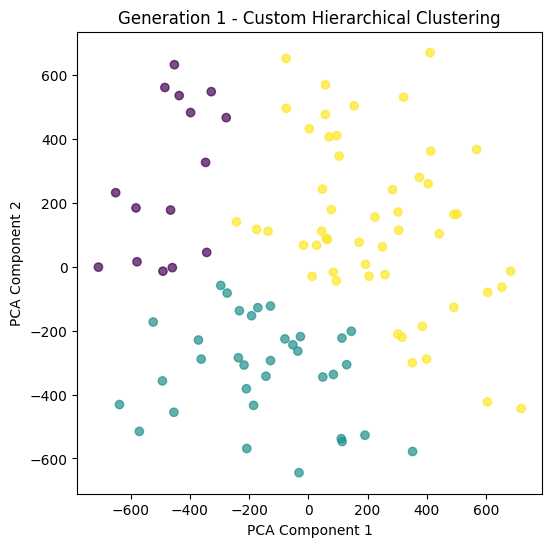

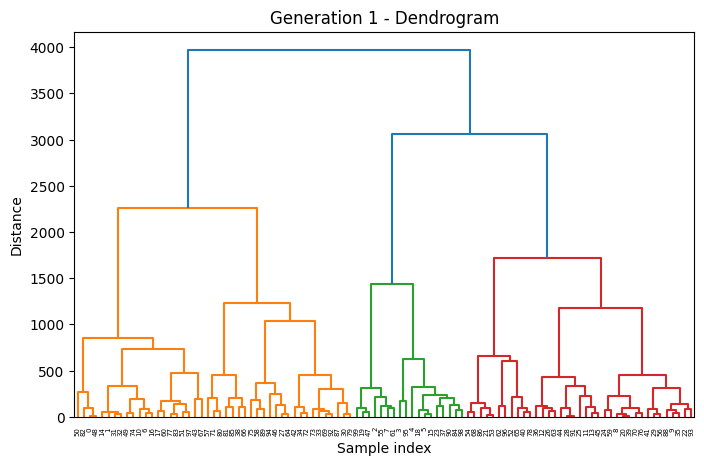

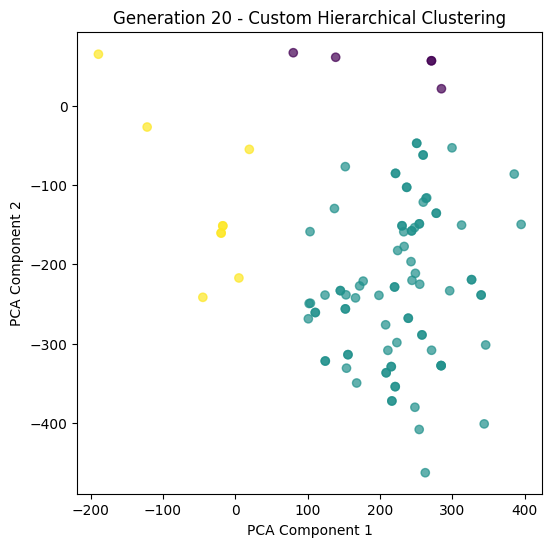

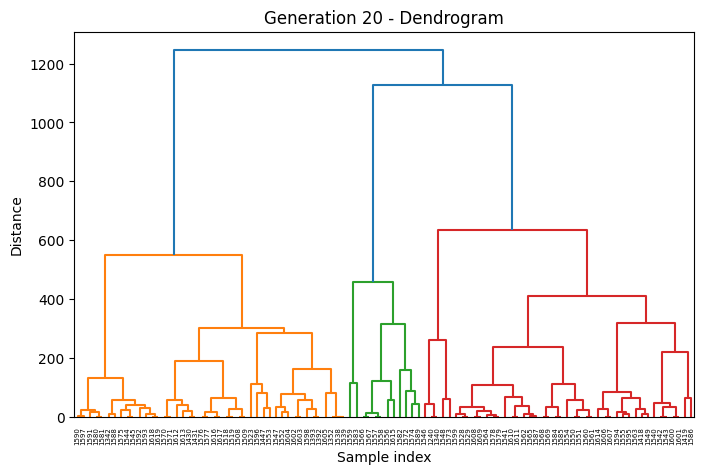

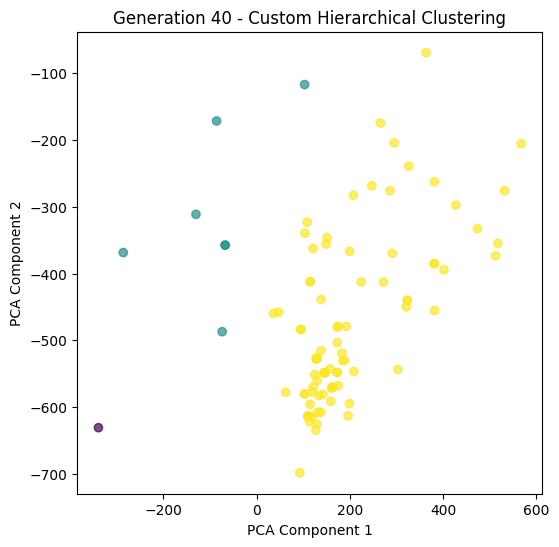

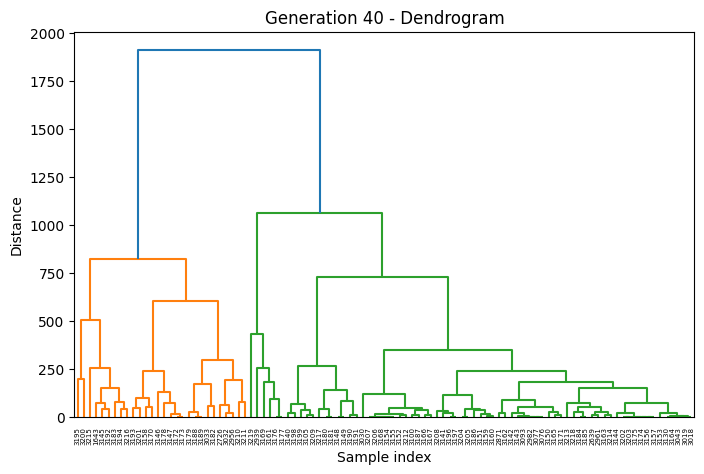

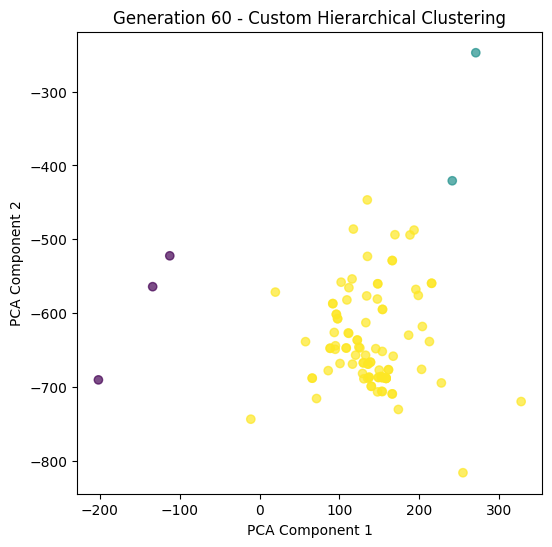

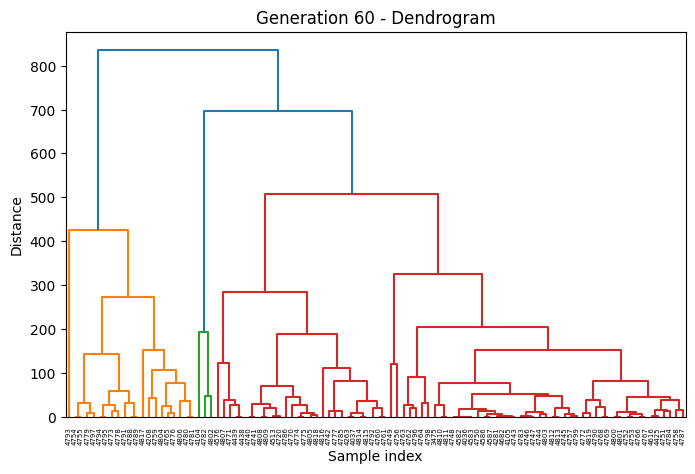

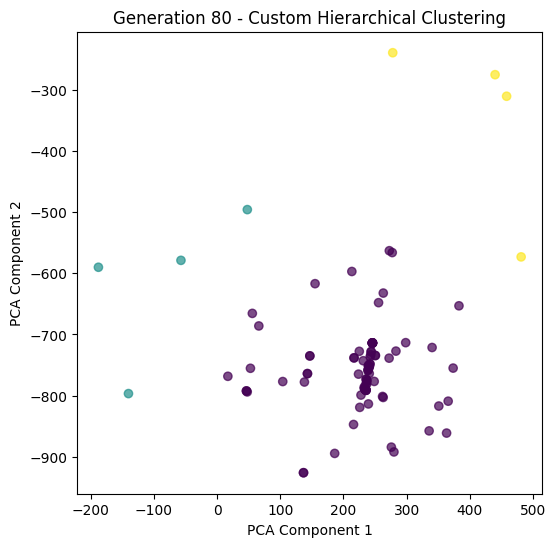

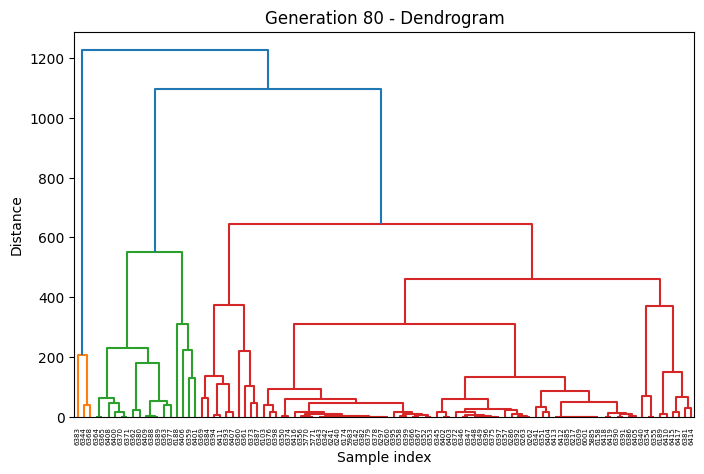

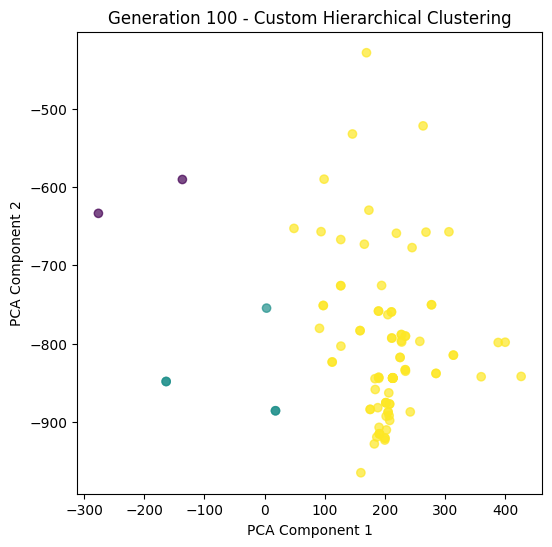

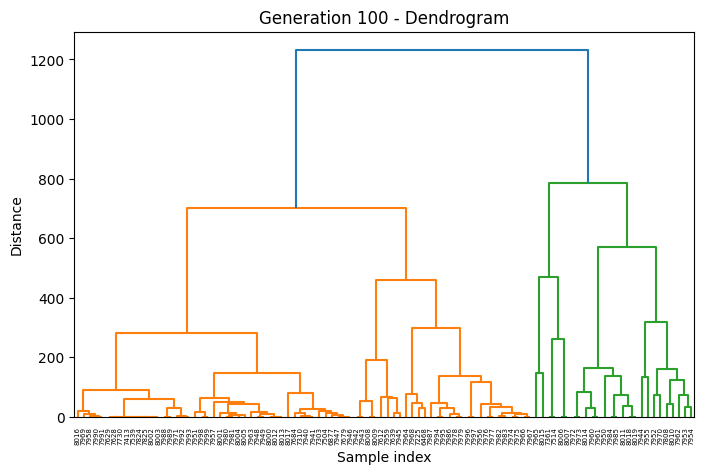

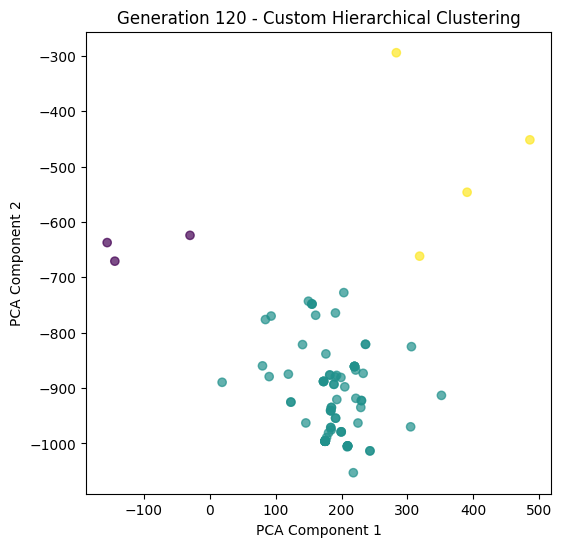

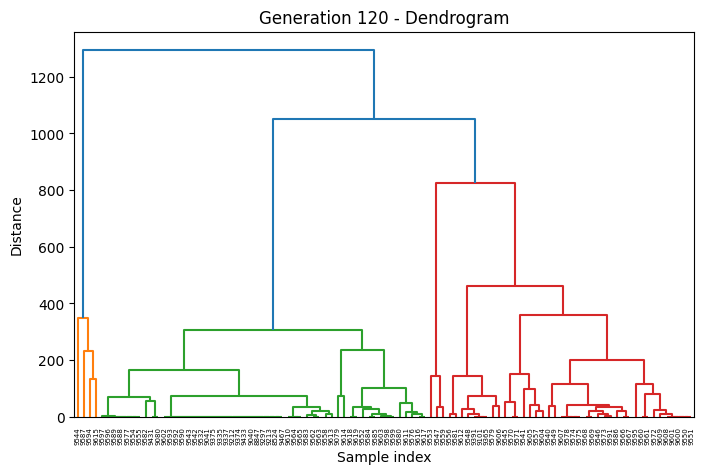

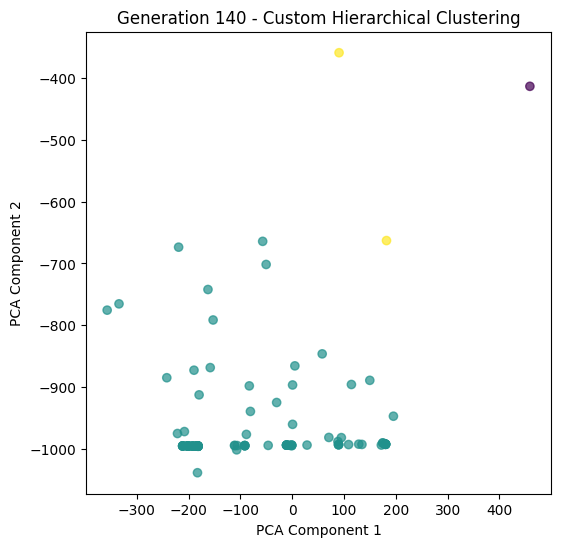

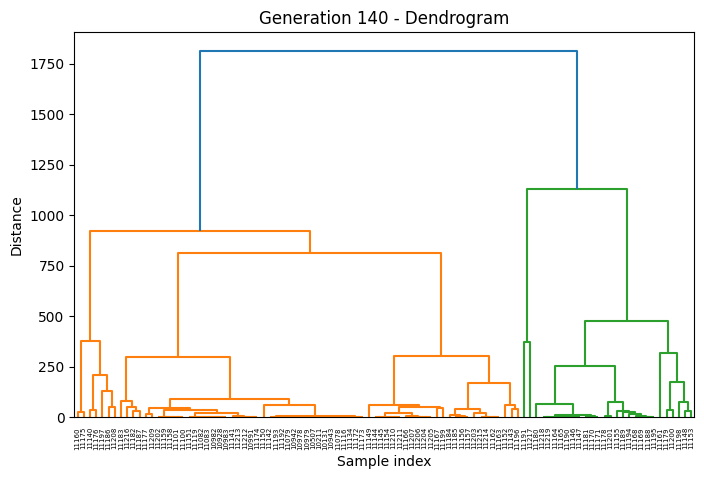

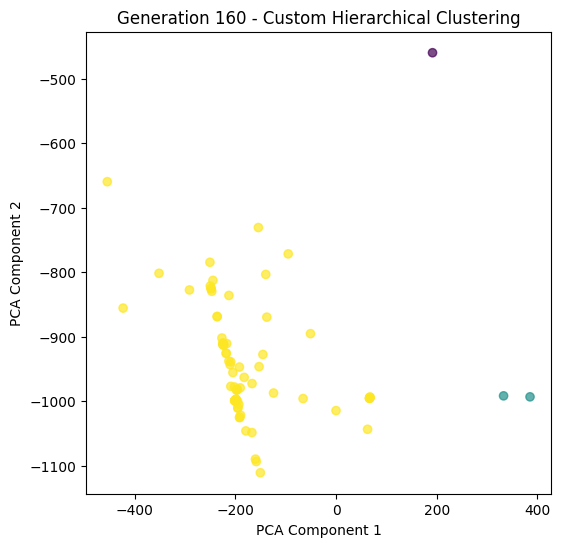

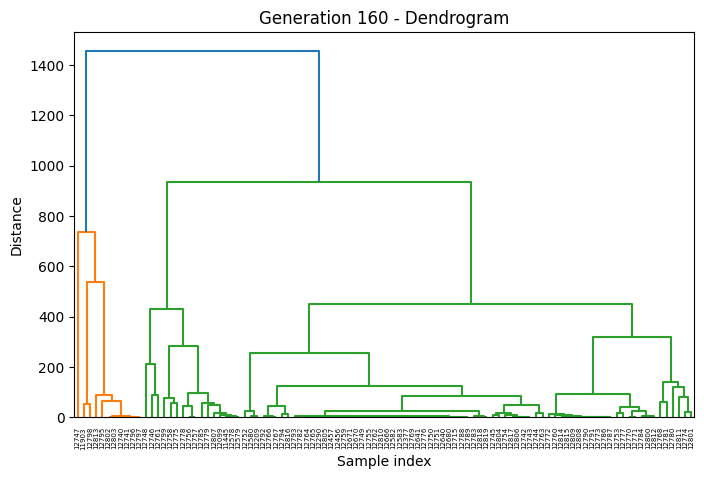

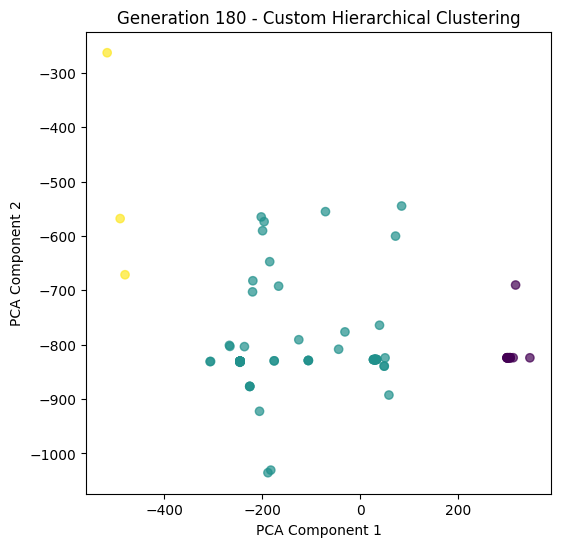

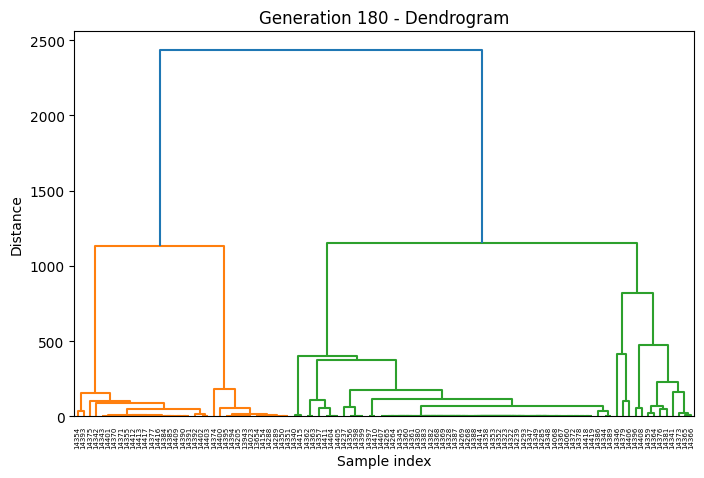

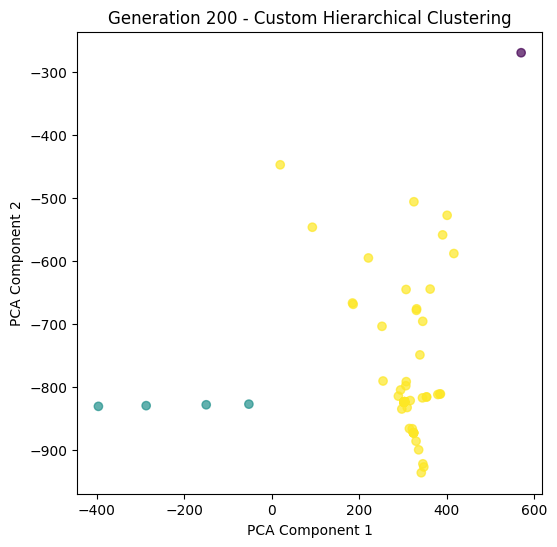

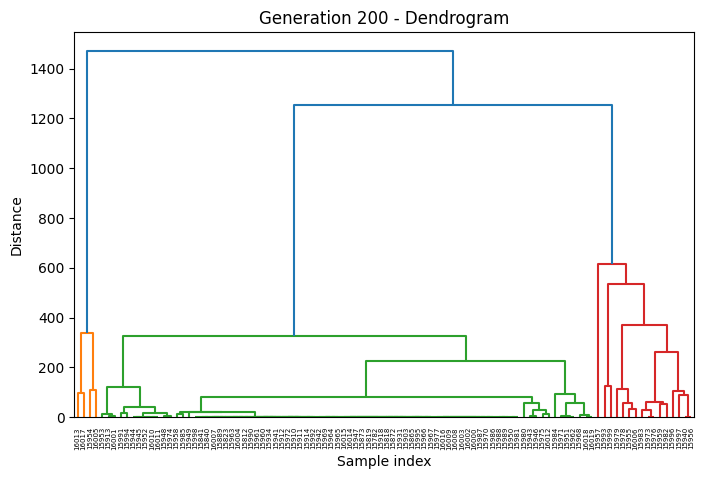

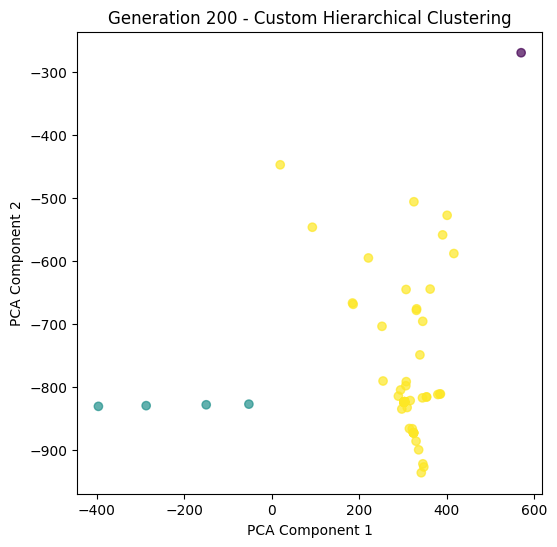

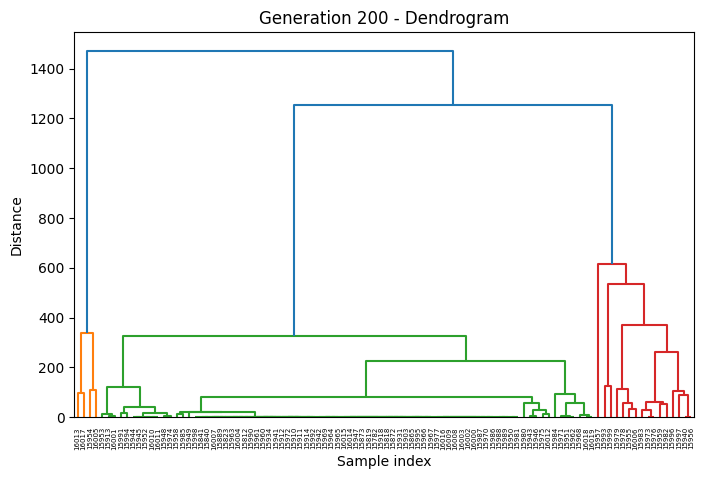

In [3]:
run("population_log_GA.csv", 3, 20)